# Detecting drift in your mobilenet model using SDK

The following demo shows you how easy it is to detect drift in your computer vision model using the Python SDK


In [1]:
import torch
import pickle
import wallaroo
import os
import numpy as np
import json
import requests
import time
import pandas as pd
from CVDemoUtils import CVDemo

from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from CVDemoUtils import CVDemo
cvDemo = CVDemo()
cvDemo.COCO_CLASSES_PATH = "models/coco_classes.pickle"

os.environ['ARROW_ENABLED'] = 'True'

### Securely connect this Notebook to the Wallaroo Cluster

In [2]:
wl = wallaroo.Client()


wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Set the current workspace to "computer-vision"

In [3]:
cvDemo.setCurrentWorkspace(wl,'cv-store-wb-v2')

### Upload the model to Wallaroo

### Upload model to wallaroo

In [4]:
model_name = 'mobilenet'
#mobilenet_model = wl.upload_model('mobilenet', "models/mobilenet.pt.onnx")
onnx_model_path = "models/mobilenet.pt.onnx"
mobilenet_model = wl.upload_model(model_name, onnx_model_path, framework=Framework.ONNX).configure('onnx', batch_config="single")


### Upload the post processing module code to Wallaroo

Next we will add our post processing anomoly detection file that will take the average of the confidences.  We will use this value to detect drift.</b>

In [5]:
import pyarrow as pa

field_boxes = pa.field('boxes', pa.list_(pa.list_(pa.float64(), 4)))
field_classes = pa.field('classes', pa.list_(pa.int32()))
field_confidences =  pa.field('confidences', pa.list_(pa.float64()))

# field_boxes - will have a flattened array of the 4 coordinates representing the boxes.  128 entries
# field_classes - will have 32 entries
# field_confidences - will have 32 entries
input_schema = pa.schema([field_boxes, field_classes, field_confidences])

output_schema = pa.schema([
    field_boxes,
    field_classes,
    field_confidences,
    pa.field('avg_conf', pa.list_(pa.float64()))
])

In [7]:
module_post_process = wl.upload_model("post-process-drift-detection-arrow-3", 
                                      "./models/post-process-drift-detection-arrow.py",framework=Framework.PYTHON ).configure('python', input_schema=input_schema, output_schema=output_schema)


### Reserve resources needed for this pipeline from the Wallaroo Cluster

In [8]:
deployment_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("1Gi").build()

### Create the pipeline and add the post processing module as a step in the pipeline

In [ ]:
#pipeline_name = 'cam-atl-1-anm'
#pipeline = wl.build_pipeline(pipeline_name) \
#            .add_model_step(mobilenet_model) \
#            .deploy(deployment_config = deployment_config)

In [9]:
pipeline_name = 'drift-detection-2'
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(mobilenet_model) \
            .add_model_step(module_post_process) \
            .deploy(deployment_config = deployment_config)

In [21]:
pipeline.deploy()

name,drift-detection-2
created,2023-07-28 16:56:59.603999+00:00
last_updated,2023-07-28 17:46:01.326097+00:00
deployed,True
tags,
versions,"8b50b241-134b-450d-a046-14af6f29ea8d, d2a13111-f347-4957-a15a-18fadd4b71fe, 8e19ac04-97f3-463c-834e-d63391325752"
steps,mobilenet


In [22]:
pipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.244.0.121',
   'name': 'engine-67bf6c599c-7bhvp',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'drift-detection-2',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'mobilenet',
      'version': 'f9f0e58e-9076-4846-870b-e22b5a5cb4b3',
      'sha': '9044c970ee061cc47e0c77e20b05e884be37f2a20aa9c0c3ce1993dbd486a830',
      'status': 'Running'},
     {'name': 'post-process-drift-detection-arrow-3',
      'version': '0891cdfd-678c-4727-8f96-829066a8910d',
      'sha': 'f60c8ca55c6350d23a4e76d24cc3e5922616090686e88c875fadd6e79c403be5',
      'status': 'Running'}]}}],
 'engine_lbs': [{'ip': '10.244.4.67',
   'name': 'engine-lb-584f54c899-j4dmn',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': []}

In [11]:

url = pipeline._deployment._url()


## Test the pipeline by running inference on a sample image

### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

In [12]:
width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe('data/images/input/example/dairy_bottles.png', width, height)

In [13]:
dfImage


,tensor
0,[[[[0.9372549 0.9529412 0.9490196 0.9450980...


# Run inference using the SDK 

Now lets have the model detect the objects on the image by running inference and extracting the results 

In [23]:
startTime = time.time()
infResults = pipeline.infer(dfImage)
endTime = time.time()


In [18]:
infResults["out.avg_conf"]

0    [0.2895053208114637]
Name: out.avg_conf, dtype: object

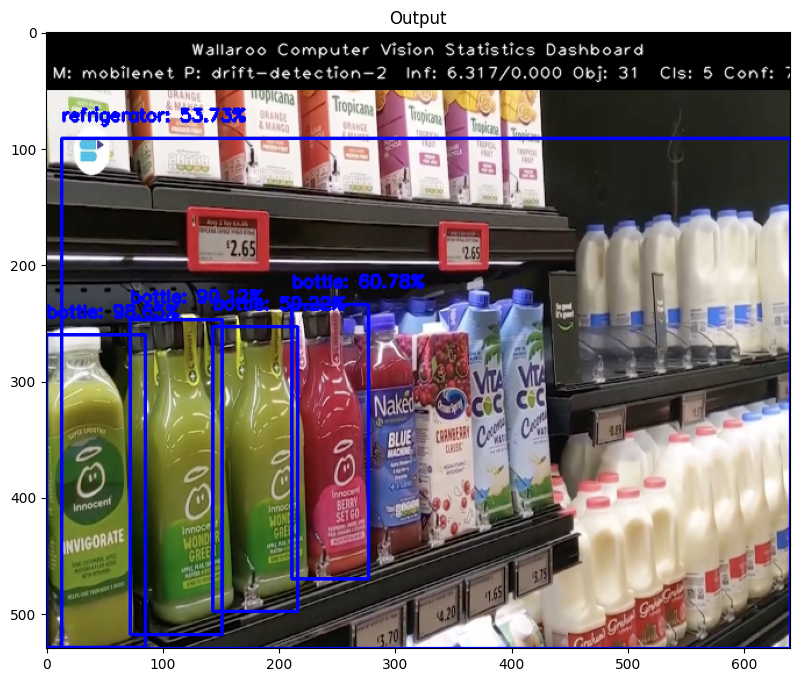

In [24]:
elapsed = 1.0
#elapsed = infResults['elapsed']
results = {
    'model_name' : model_name,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : infResults,
    'confidence-target' : 0.50,
    'inference-time': (endTime-startTime),
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(results)

In [25]:
pipeline.logs()

,time,in.tensor,out.avg_conf,out.boxes,out.classes,out.confidences,check_failures
0,2023-07-28 16:57:39.001,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0
1,2023-07-28 17:46:32.384,None,[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, ...","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 4...","[0.98649001121521, 0.9011535644531251, 0.60778...",0



### To get the list of assays in this workspace

In [ ]:
wl.list_assays()

[]

### Creating an Assay

An assay measures how far an inference is drifting from some ground truth baseline.  Where the baseline has been verified to be an accurate prediction.

To setup an assay we need the following attributes

assay_name - user friendly name 
pipeline - that will run the inferences for a given model
baseline_start - the start date and time for the ground truth
baseline_end - the end date and time for the ground truth

The assay will look in the logs for the baseline date range provided to extract the ground truth that we will compare the inferences to in order to detect drift.

automates detecting drift by allowing you to build a schedule for when we should perform the calculation of detecting drift. 

In [ ]:
model_name

In [ ]:
import datetime
baseline_start = datetime.datetime.fromisoformat('2023-07-25T00:00:00+00:00')
baseline_end = datetime.datetime.fromisoformat('2023-07-25T17:19:00+00:00')
#baseline_start = datetime.datetime.now()
#baseline_end = datetime.datetime.today()

assay_name = "assayavgconfv2"
assay_builder = wl.build_assay(assay_name, pipeline, "post-process-drift-detection-arrow-3", baseline_start, baseline_end).add_iopath("output avg_conf 0")

In [ ]:
baseline_run = assay_builder.build().interactive_baseline_run()

### Schedule Assay

By default assays are scheduled to run every 24 hours starting immediately after the baseline period ends. This scheduled period is referred to as the assay window and has the following properties:

* width: The period of data included in the analysis. By default this is 24 hours.
interval:
* How often the analysis is run (every 5 minutes, every 24 hours, etc). By default this is the window width.
* start: When the analysis should start. By default this is at the end of the baseline period.


In [ ]:
assay_builder.window_builder().add_width(minutes=1).add_interval(=1)


In [ ]:
assay_config = assay_builder.build()


In [ ]:
df=assay_builder.baseline_dataframe()
df

In [ ]:
assay_results = assay_config.interactive_run()
print(f"Generated {len(assay_results)} analyses")


In [ ]:
assay_builder.baseline_histogram()


Lets load a video so we can run inference and record the average confidences in the log over an extended time period.

In [ ]:

# The size the image will be resized to
width = 640
height = 480

input_video = "data/videos/input/camera-simulator.mp4"
#input_video = "videos/camera2.mp4"
output_video = "data/videos/output/cam-atl-drift-inferenced.mp4"
save_frames_path = "images/output"
#input_video = "videos/ww2-warbirds-in-formation.mp4"
#output_video = "videos/ww2-warbirds-in-formation-inferenced.mp4"

while True:
    config = {
        'arrow' : True,
        'input-video' : input_video, # source video
        'output-video' : output_video, # show the input video with the inferenced results drawn on each frame
        'save-frames-path' : save_frames_path, # show the input video with the inferenced results drawn on each frame
        'fps' : 15, # Frames per second
        'endpoint-url' : url, # the pipelines rest api endpoint url
        'width' : width, # the width of the url
        'height' : height, # the height of the url
        'max-frames' : 800, # the # of frames to capture in the output video
        'skip-frames' : 700, # the # of frames to capture in the output video
        'confidence-target' : 0.10, # only display bounding boxes with confidence > provided #
        'color':CVDemo.CYAN, # color to draw bounding boxes and the text in the statistics
        'inference' : 'WALLAROO_SDK', # "ONNX" or "WALLAROO_API" or "WALLAROO_SDK"
        'onnx_model_path' : onnx_model_path,
        'model_name' : model_name,
        'pipeline' : pipeline, # provide this when using inference WALLAROO_SDK 
        'pipeline_name' : pipeline_name,
        'confidence-target' : 0.10,
        'skip-frames-list' :[(440,460)]
    #    'record-start-frame' : 225, # the # of frames to capture in the output video
    #    'record-end-frame' : 275, # the # of frames to capture in the output video  
    }
    cvDemo.DEBUG = False
    if cvDemo.detectAndClassifyObjectsInVideo(config) == False:
        break
        
print("We are done.")




    

-- walInfResult --
                     time                                          in.tensor  \
0 2023-07-25 17:19:31.452  [0.9294117689, 0.9294117689, 0.9333333373, 0.9...   

            out.avg_conf                                          out.boxes  \
0  [0.11018175892531819]  [[23.21565055847168, 17.79254913330078, 60.023...   

                                out.classes  \
0  [44, 44, 82, 82, 61, 44, 61, 61, 44, 61]   

                                     out.confidences  check_failures  
0  [0.193713665008544, 0.19115251302719102, 0.139...               0  
07-25-2023 17:19:31.827165 Frame:725 Read: 0.0006 Inf: 0.6535 Onnx: 1.0000 Draw: 0.0010 Total: 0.7000
-- walInfResult --
                     time                                          in.tensor  \
0 2023-07-25 17:19:32.156  [0.9450980425, 0.9450980425, 0.9490196109, 0.9...   

            out.avg_conf                                          out.boxes  \
0  [0.09589722131689334]  [[400.3111267089844, 236.139495849609

### View drift in Dashboard 

Let the above period run for several hours

* Go to the pipeline in the dashboard.
* Select the Insights tab.
* Create an assay.
* Set the the baseline date range.
* Preview the distribution results.
* Preview the results for the week.
* Set the threshold appropriately.
* Save the assay.


In [17]:

pipeline.undeploy()


#for d in wl.list_deployments():
#    d.undeploy()
    

name,drift-detection-2
created,2023-07-28 16:56:59.603999+00:00
last_updated,2023-07-28 16:57:01.446201+00:00
deployed,False
tags,
versions,"d2a13111-f347-4957-a15a-18fadd4b71fe, 8e19ac04-97f3-463c-834e-d63391325752"
steps,mobilenet
